# Maps

In this section, we have focused on learning the basics of the “cartopy” python library so we can plot different maps from our study zone. The main objective was to create some useful functions that allow us to plot simple maps from our study zone. We created two functions. The first one (mapa) plots a map from our study zone and the different CTD stations. The second one (map_layers) was created to help with the analysis of the layers’ classification and plots a map of the study zone where the different CTD stations are coloured according to their number of layers. Both functions are stored in the python file “maps.py”.

## Mapping the Study Zone

In [2]:
#First, some imports
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import pandas as pd
import numpy as np

#Now we read the data
from read_CTD import read_CTD
data_dirs = ['C:/Users/Pau/Data/TFM/CTD_proc_files_1mbin/']
data=read_CTD(data_dirs)

#And delete the outliers
from out_outliers import out_outliers
for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)

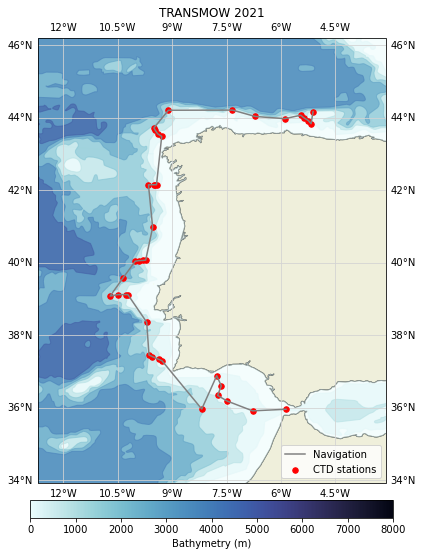

In [5]:
#Creating the map
#First, we create the figure
fig = plt.figure(figsize=(10,10))
m1 = fig.add_subplot(projection=ccrs.PlateCarree())     #projection PlateCarree

#Add features
m1.add_feature(cfeature.LAND, edgecolor='lightyellow')
m1.coastlines('10m')

#Add the bathymetry from Natural Earth (code from https://nbviewer.org/gist/pelson/626b15ffc411a359381e)
cmap = cmocean.cm.ice_r      #Bathymetry color bar
norm = plt.Normalize(0, 8000)  #Normalize the colors from 0m to 8000m
#Import the bathymetry layers
for letter, level in [
                          ('L', 0),
                          ('K', 200),
                          ('J', 1000),
                          ('I', 2000),
                          ('H', 3000),
                          ('G', 4000),
                          ('F', 5000)]:
                          #('E', 6000),
                          #('D', 7000)]:
                          #('C', 8000),
                          #('B', 9000),
                          #('A', 10000)]:
        bathym = cfeature.NaturalEarthFeature(name='bathymetry_{}_{}'.format(letter, level),
                                     scale='10m', category='physical')
        m1.add_feature(bathym, facecolor=cmap(norm(level)), edgecolor='face', alpha=0.5)  #alpha=transparency

#Stablish the map limits
#Store the coordinates of all the stations of interest
ncasts = data.keys()     #We select all the stations
longitudes = []
latitudes = []
for ncast in ncasts:
    longitudes.append(data[ncast]['longitude'].iloc[0])
    latitudes.append(data[ncast]['latitude'].iloc[0])
#Margins
xoffset=2
yoffset=2
#Store coordinates maximums and minimums to stablish the map limits
min_lon = min(longitudes)
max_lon = max(longitudes)
min_lat = min(latitudes)
max_lat = max(latitudes)
#Map limits
m1.set_extent([min_lon-xoffset, max_lon+xoffset, min_lat-yoffset, max_lat+yoffset])

#Add the CTD station points
for ncast in ncasts:
    m1.scatter(data[ncast].longitude.iloc[0], data[ncast].latitude.iloc[0], color='red',s=30, transform=ccrs.PlateCarree(),zorder=10)

#Add lines to show the navigation between stations
m1.plot(longitudes, latitudes, color='grey', transform=ccrs.PlateCarree(), zorder=11)

#Add legend
m1.legend(['Navigation','CTD stations'], loc='lower right')

#Add the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = plt.colorbar(sm, orientation='horizontal', shrink=0.65, pad=0.03, label = 'Bathymetry (m)')
plt.title('TRANSMOW 2021')
m1.gridlines(crs=ccrs.PlateCarree() ,draw_labels=True, color='lightgrey')
plt.show()

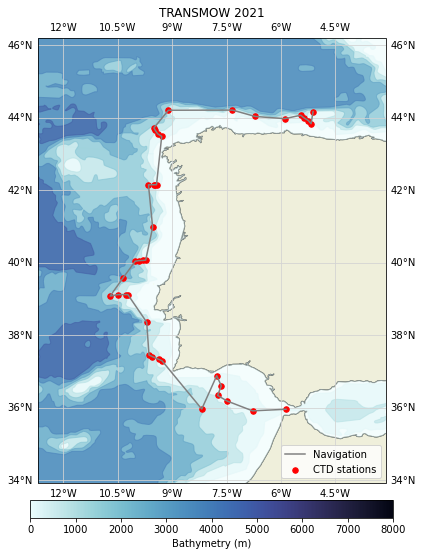

In [6]:
#We created a function (mapa) that resumes all the code to plot maps from our study zone
from maps import mapa, map_layers
mapa(data, ncasts=data.keys(), lines=True)

### Mapping the layers' classification 

We created a function to observe the layers' classification in differents maps of the different number of layers.

Layers' classification of the 1st approach


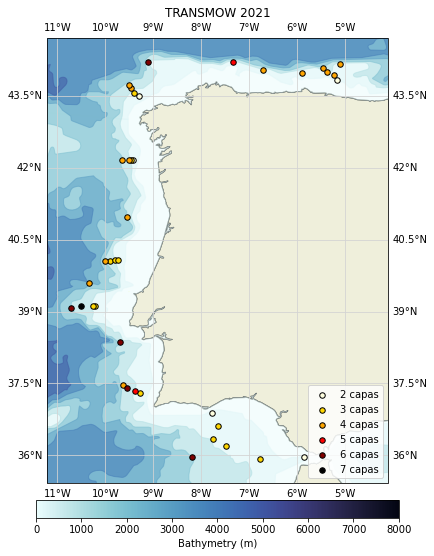


Layers' classification of the 2nd approach


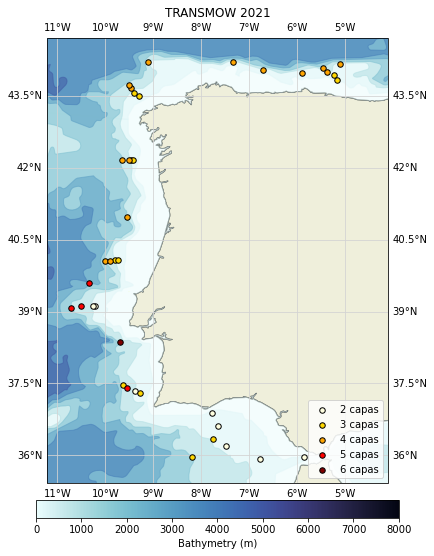


Layers' classification of the 3rd approach


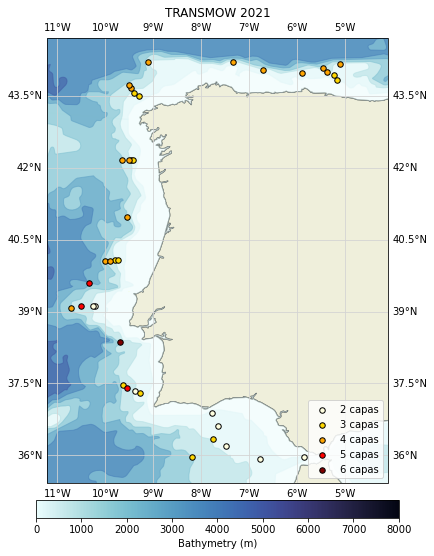

In [19]:
#Code that creates the layers' classification tables
#Import the different functions that correspond to the different approaches that determines the layers of a vertical profiles
from inflexion_points import inflexion_points     #1st approach
from maxmin import maxmin, maxmin_2               #2nd and 3rd approach
#We will smooth the profiles with a lamb=5.000.000 except for the 1st that will be of 50.000.000
lamb=5000000

#1st we create a series that contains the number of layers of each profile
table1 = pd.Series(dtype=np.int64)
table2 = pd.Series(dtype=np.int64)
table3 = pd.Series(dtype=np.int64)
for ncast in data.keys():
    table1[ncast]=inflexion_points(data, ncast, lamb=50000000)    #Series of the 1st approach
    table2[ncast]=maxmin(data, ncast, lamb=lamb)              #Series of the 2nd approach
    table3[ncast]=maxmin_2(data, ncast, lamb=lamb)            #Series of the 3rd approach
    
#Now, we transform the series and create a table that classifies the profiles according to their number of layers
layers1 = pd.Series(index=set(table1.values), dtype=np.int64)
layers2 = pd.Series(index=set(table2.values), dtype=np.int64)
layers3 = pd.Series(index=set(table3.values), dtype=np.int64)

for a, b, c in zip(table1.values, table2.values, table3.values):
    #print(a,b,c)
    layers1[a]=list(table1[table1==a].index)
    layers2[b]=list(table2[table2==b].index)
    layers3[c]=list(table3[table3==c].index)
layers1.index.name = '1st approach. Nº of layers - [ncast profile]'
layers2.index.name = '2nd approach. Nº of layers - [ncast profile]'
layers3.index.name = '3rd approach. Nº of layers - [ncast profile]'

#Code to plot the layers' classification
from maps import map_layers
colors = ['lightyellow','gold','orange','red','maroon','black']
colors1 = ['lightyellow','gold','red','maroon','blueviolet']
colors2 = ['white','pink','magenta','darkviolet','blue']
print('Layers\' classification of the 1st approach')
map_layers(data, layers1, colors=colors)
print()
print('Layers\' classification of the 2nd approach')
map_layers(data, layers2, colors=colors)
print()
print('Layers\' classification of the 3rd approach')
map_layers(data, layers3, colors=colors)

We also can create maps to see where are the profiles of a certain number of layers. Let's create them using the 3rd approach.

     Profiles with  2  layers


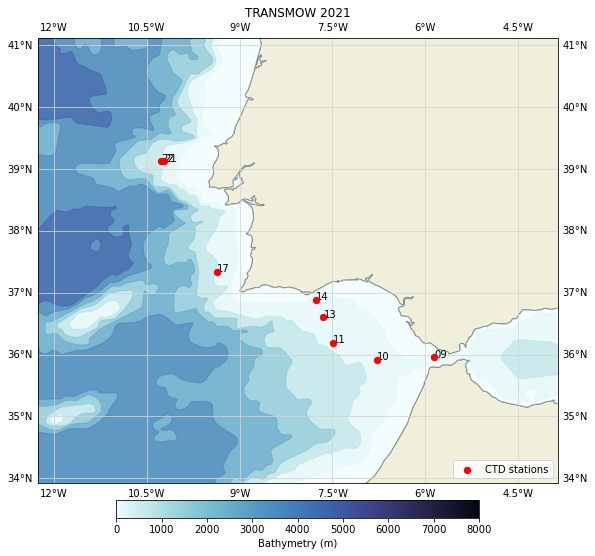



     Profiles with  3  layers


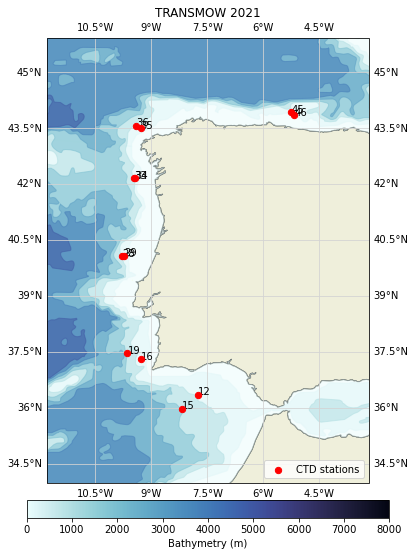



     Profiles with  4  layers


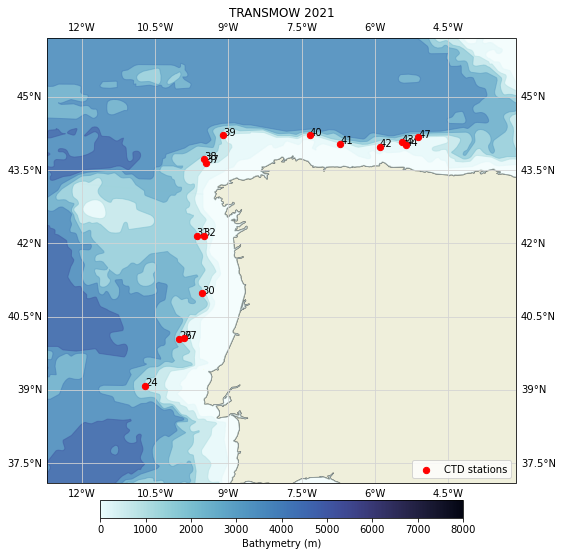



     Profiles with  5  layers


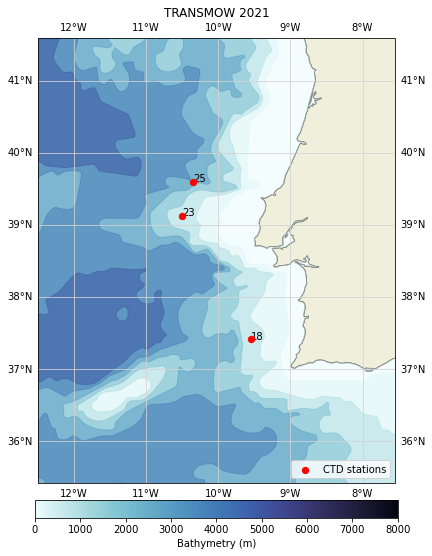



     Profiles with  6  layers


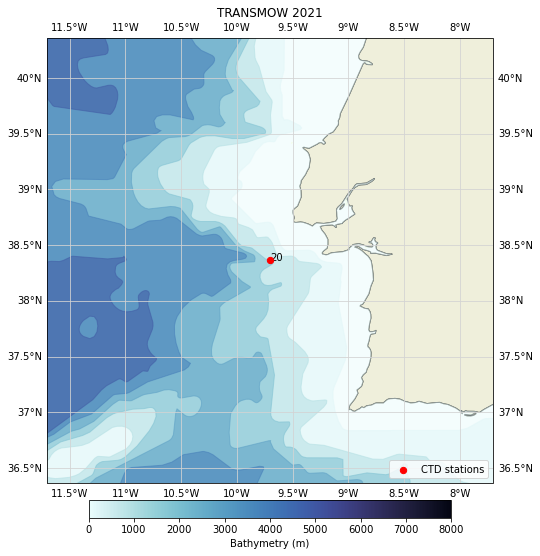

In [20]:
#Code to create the maps of the diferent profiles according to their number of layers
for i in layers3.index:
    ncasts=layers3[i]
    print('     Profiles with ',str(i),' layers')
    mapa(data, ncasts, xoffset=2, yoffset=2, s=40, labels=True)
    print()
    print()